## Description

In this notebook, we compare the outcomes of different approaches to annotation of spectra of lipids in the context of MS imaging:  
  - Accurate mass matching in the average spectrum (a commonly used approach)
  - Matching theoretical spectra to the average spectrum using `masserstein` 
  - Deconvolving each pixel independently with `masserstein`  
  
We use a custom set of lipid formulas downloaded from LIPID MAPS data base. The set of lipids is supplied with the notebook.  

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as rd
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
from venn import venn
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra
from collections import Counter

In [3]:
analyzed_mass_range = (700, 900)
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

Load the images in profile mode and the centroided MS images calculated in Notebook 2:

In [4]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [5]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

Load the average spectra calculated in Notebook 2:

In [6]:
average_spectra = {}
average_spectrum_masses = {}
for i, n in enumerate(image_names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra[n] = sp
    average_spectrum_masses[n] = [x[0] for x in sp.confs]

Average spectra in profile mode will be used for visualization and visual verification of the annotations

In [7]:
profile_average_spectra = {}
for i, n in enumerate(image_names):
    sp = open(n + '_profile_summary_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(l[0]), float(l[1])) for l in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    profile_average_spectra[n] = sp

Load the lipid formulas:

In [8]:
lipid_formulas = []
formula_to_subclasses = {}
formula_to_classes = {}
formula_to_IDs = {}
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        formula = l[3] 
        lipid_class = l[1]
        lipid_subclass = l[2]
        lipid_ID = l[0]
        if set(formula).issubset(set('CHNOP0123456789')): # skipping atypical formulas, e.g. with Deuterium
            lipid_formulas.append(formula)
            try:
                formula_to_subclasses[formula].append(lipid_subclass)
            except KeyError:
                formula_to_subclasses[formula] = [lipid_subclass]
            try:
                formula_to_classes[formula].append(lipid_class)
            except KeyError:
                formula_to_classes[formula] = [lipid_class]
            try:
                formula_to_IDs[formula].append(lipid_ID)
            except KeyError:
                formula_to_IDs[formula] = [lipid_ID]
lipid_formulas = list(set(lipid_formulas))
nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))
print('Loaded %i unique lipid formulas' % len(lipid_formulas))
print('Loaded %i unique lipid classes' % nb_of_classes)
print('Loaded %i unique lipid subclasses' % nb_of_subclasses)
print('Loaded %i unique lipid IDs' % nb_of_IDs)

Loaded 3523 unique lipid formulas
Loaded 2 unique lipid classes
Loaded 30 unique lipid subclasses
Loaded 14454 unique lipid IDs


Generate the lipid reference spectra (assuming a potassium adduct). We'll take the peaks that are at least 5% as high as the highest one.  

In [9]:
lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in lipid_formulas]
for s in lipid_spectra: 
    s.normalize()

We'll discard the spectra that are outside of our desired mass range and we'll get the lipid classes corresponding to the remaining formulas (note that the correspondence is not 1-to-1: one formula may corresponds to lipids from multiple classes)

In [10]:
is_mass_within_range = [analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1] for s in lipid_spectra]
lipid_spectra = [s for t, s in zip(is_mass_within_range, lipid_spectra) if t]
lipid_formulas = [s for t, s in zip(is_mass_within_range, lipid_formulas) if t]
assert all(s.formula == f for s,f in zip(lipid_spectra, lipid_formulas))

formula_to_subclasses = {f: formula_to_subclasses[f] for f in lipid_formulas}
formula_to_classes = {f: formula_to_classes[f] for f in lipid_formulas}
formula_to_IDs = {f: formula_to_IDs[f] for f in lipid_formulas}

nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))

print('Retained %i lipid spectra' % len(lipid_spectra))
print('Retained %i classes' % nb_of_classes)
print('Retained %i subclasses' % nb_of_subclasses)
print('Retained %i IDs' % nb_of_IDs)

Retained 1206 lipid spectra
Retained 2 classes
Retained 22 subclasses
Retained 6922 IDs


Get the monoisotopic masses of our lipid ions:

In [11]:
# lipid_masses = [s.confs[0][0] for s in lipid_spectra]

Example theoretical spectrum:

<IPython.core.display.Javascript object>


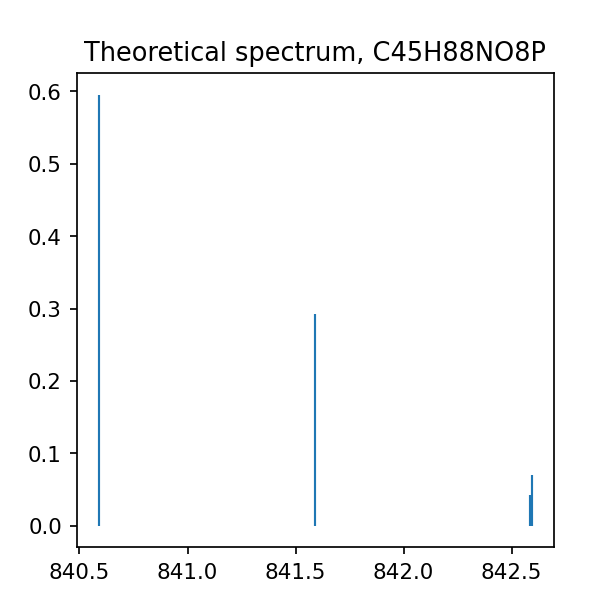

In [12]:
plt.figure(figsize=(4,4))
i = 1000
plt.title('Theoretical spectrum, %s' % lipid_spectra[i].formula)
lipid_spectra[i].plot()
plt.show()

## Mass matching accuracy settings

In [13]:
proportion_threshold = 1e-10
MTD = 0.005
MTD_th = 0.015

Note: MTD_th needs to be higher than MTD, otherwise the spectra can fit to "nothingness".   
MTD_th=0.005 gives us theoretical spectra without corresponding experimental signal.   
Another reason to set MTD_th > MTD is that it's easier to get too much signal in the analyzed spectrum (due to noise) than to miss some signal (due to LOD).  

## Fast strategy: annotation of the average spectrum.  
Referred to as the "average, then annotate" strategy.  

In [14]:
proportions_in_average = {}
regression_times = {}
for n in image_names:
    av_sp = average_spectra[n]
    s = time()
    regression = estimate_proportions(av_sp, lipid_spectra, MTD=MTD, MTD_th=MTD_th)
    e = time()
    proportions_in_average[n] = np.array(regression['proportions'])
    regression_times[n] = e-s
print('Regression times:')
print(regression_times)

Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1760644.14it/s]
Splitting the experimental spectrum into chunks: 3207it [00:00, 2825274.72it/s]
Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:00<00:00, 2413607.25it/s]
Splitting the experimental spectrum into chunks: 423it [00:00, 683169.27it/s]
Deconvolving chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.66it/s]

Regression times:
{'cerebellum': 5.1165900230407715, 'bladder': 1.2233335971832275}


<IPython.core.display.Javascript object>


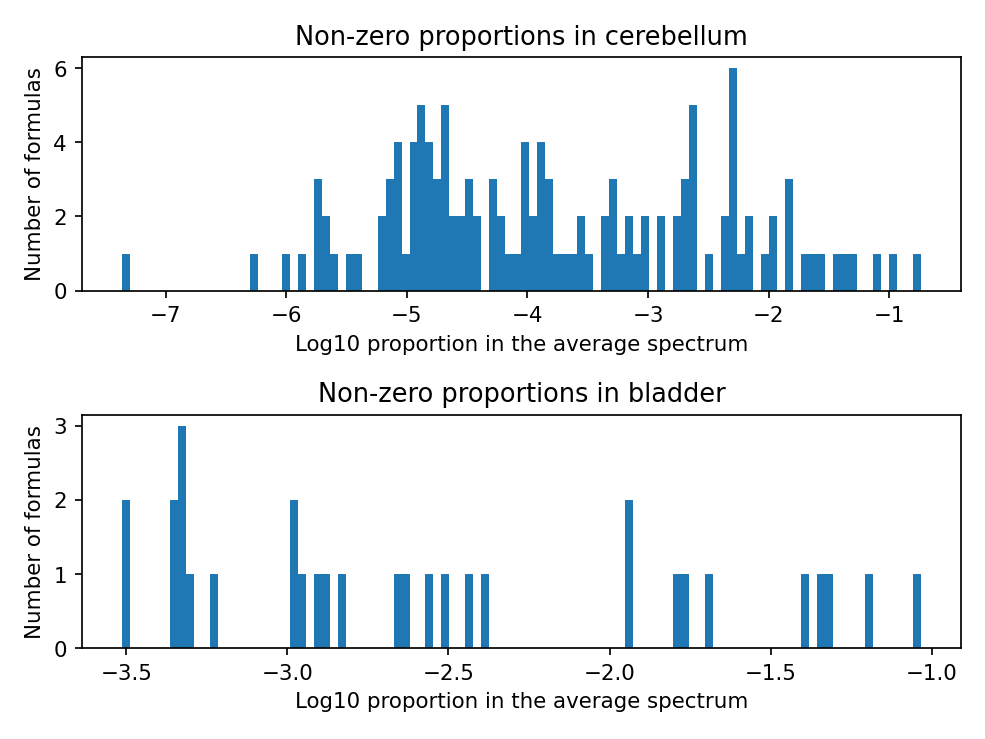

Number of non-zero proportions in cerebellum 128
Number of non-zero proportions in bladder 31


In [15]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    pvect = proportions_in_average[n]
    plt.hist(np.log10(pvect[pvect>0]), bins=100)
    plt.title('Non-zero proportions in ' + n)
    plt.xlabel('Log10 proportion in the average spectrum')
    plt.ylabel('Number of formulas')
    print('Number of non-zero proportions in', n, sum(pvect>0))
plt.tight_layout() 

<IPython.core.display.Javascript object>


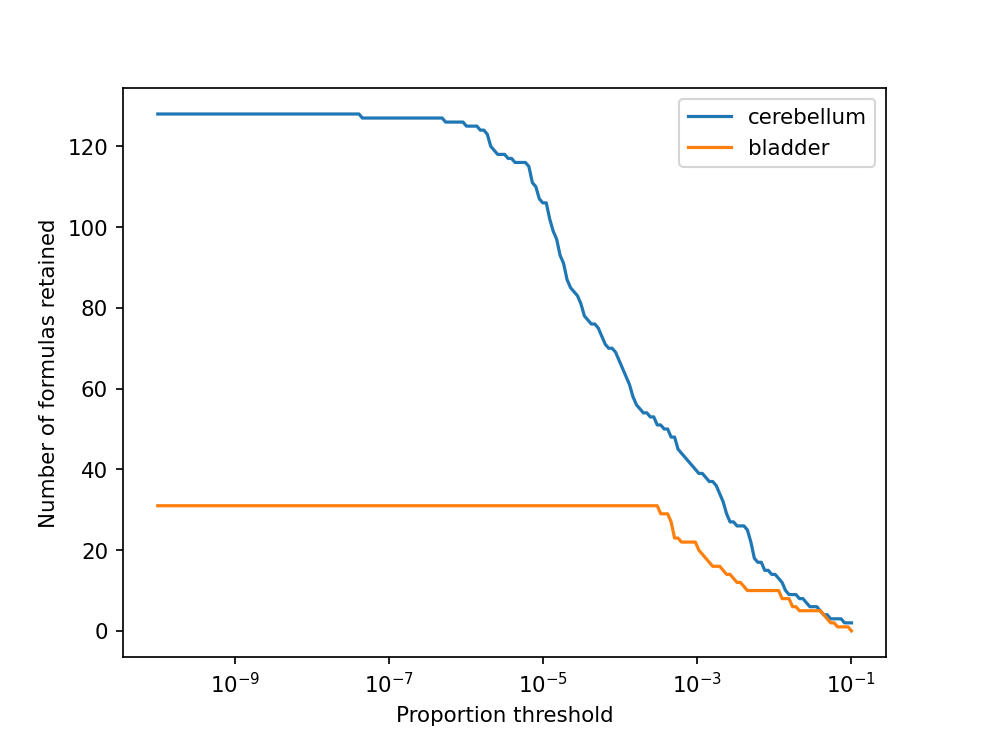

Text(0, 0.5, 'Number of formulas retained')

In [16]:
proportion_thresholds = 10**np.linspace(-10, -1, num=201)
remaining_ions = {n: [sum(proportions_in_average[n]>thr) for thr in proportion_thresholds] for n in image_names}

plt.figure()
plt.plot(proportion_thresholds, remaining_ions['cerebellum'])
plt.plot(proportion_thresholds, remaining_ions['bladder'])
plt.gca().set_xscale('log')
plt.legend(['cerebellum', 'bladder'])
plt.xlabel('Proportion threshold')
plt.ylabel('Number of formulas retained')

Select the threshold of proportions for an ion to be considered present in the spectrum:  

In [17]:
proportion_threshold_strategy1 = 0.0  # the proportions needs to be above this threshold

In [18]:
is_annotated_strategy1 = {}
for n in image_names:
    to_keep = proportions_in_average[n] > proportion_threshold_strategy1
    is_annotated_strategy1[n] = to_keep
    print('Retained %i spectra for %s' % (sum(to_keep), n))

Retained 128 spectra for cerebellum
Retained 31 spectra for bladder


<IPython.core.display.Javascript object>


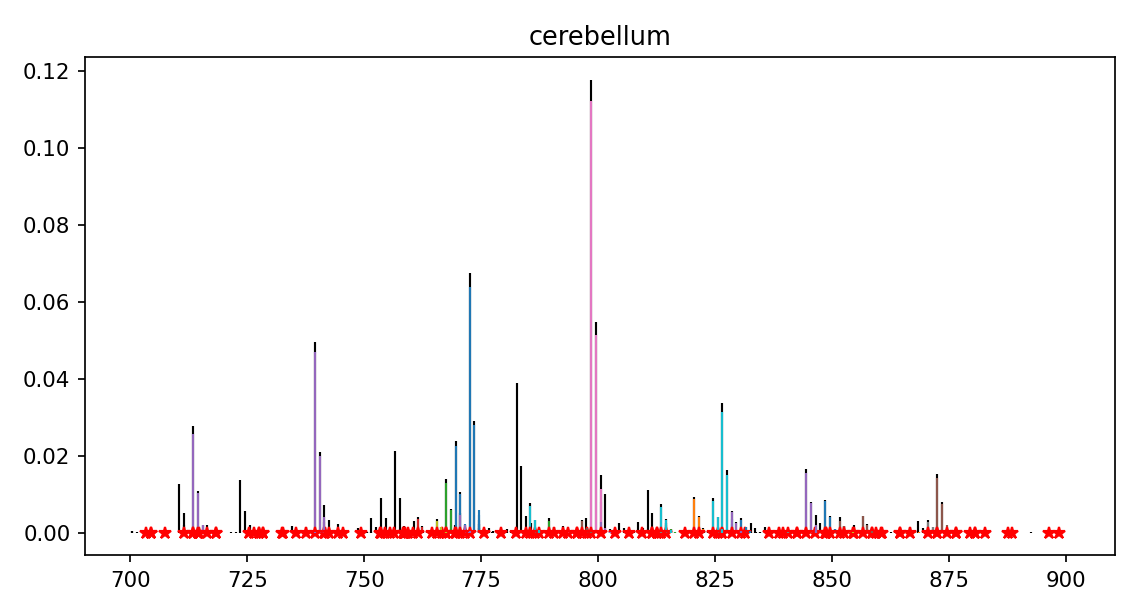

<IPython.core.display.Javascript object>


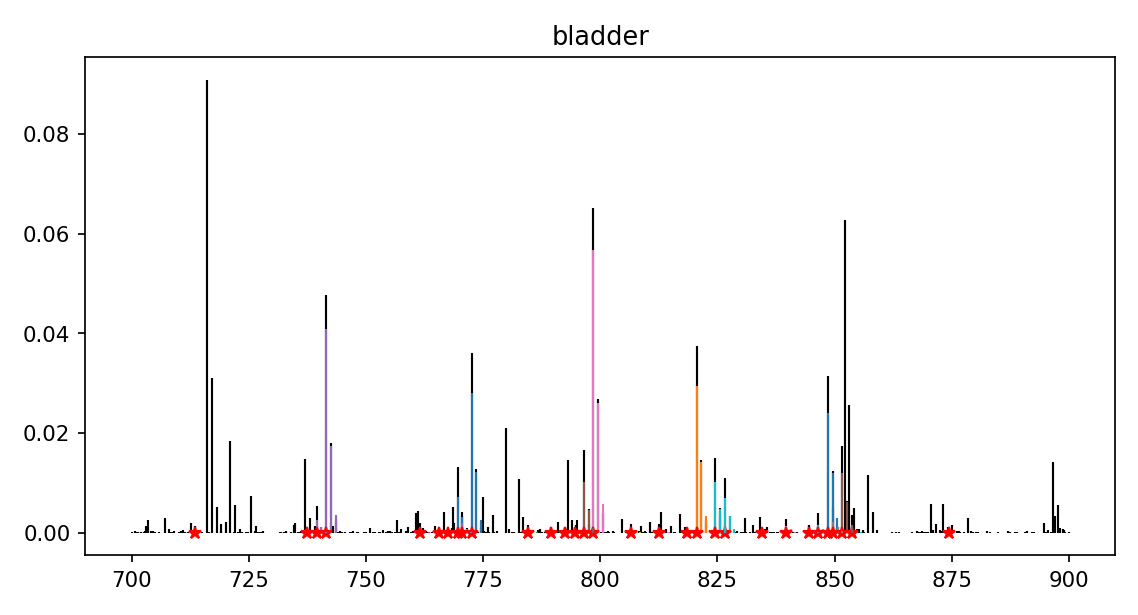

In [19]:
for i, n in enumerate(image_names):
    props = proportions_in_average[n]
    det = is_annotated_strategy1[n]
    
    plt.figure(figsize=(7.4,4))
    plt.title(n)
    average_spectra[n].plot(profile=False, color='k', show=False)
    
    for l_id, s, p, d in zip(range(len(lipid_spectra)), lipid_spectra, props, det):
        if d:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_average_then_annotate_spectrum.png', dpi=300)
    plt.show()

In [20]:
for i,n in enumerate(image_names):
    with open(n + '_fast_annotation_results.tsv', 'w') as h:
        props = proportions_in_average[n]
        det = is_annotated_strategy1[n]
        
        # Write the header
        h.write('\t'.join(['Formula', 'Mass', 'Initial proportion', 'Assigned']) + '\n')
        
        # Write the annotated formulas with their initially estimated proportions
        for l_id, s, p, d in zip(range(len(lipid_spectra)), lipid_spectra, props, det):
            mz = round(s.confs[0][0], 4)
            p = round(p, 4)
            h.write('\t'.join([s.formula, str(mz), str(p), str(d)]) + '\n')

## Thorough strategy: whole-image Masserstein deconvolution  
Referred to as the "annotate, then average" strategy, or annotation pooling

We will keep track of the total estimated proportion for each lipid, and the number of pixels in which this lipid had a non-zero proportion. This saves memory compared to keeping the deconvolved ion image for each lipid at this stage. However, to validate the estimation, we will save deconvolved ion images for selected ions. Note that since we estimate the proportions through linear spectral deconvolution, the correctness of estimation depends on the correctness of deconvolution.  

The control lipids below are based on a manual annotation of the average spectrum; these are common lipids that should be present in typical images. It is important that they do not have any inferences due to overlapping isotopic envelopes, so that their single ion images are expected to be nearly identical before and after deconvolution.  

In [21]:
control_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
control_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
control_lipid_spectrum_ids = [lipid_formulas.index(f) for f in control_lipid_formulas]
assert all(lipid_spectra[i].formula == f for i,f in zip(control_lipid_spectrum_ids, control_lipid_formulas))

We use TIC-normalized, centroided images for annotation.  
The code below may run for a long time (20 min for the cerebellum, 2h for the bladder).  

In [22]:
proportions_in_whole = {n: np.zeros(len(lipid_spectra)) for n in image_names}
number_of_nonzero_pixels = {n: np.zeros(len(lipid_spectra)) for n in image_names}
control_lipid_images = {n: np.zeros(image_shapes[n] + (3, )) for n in image_names}

# Total signal images for normalization purposes. 
# global = whole spectra; local = restricted to the analyzed mass range.  
global_tic_images = {n: np.zeros(image_shapes[n]) for n in image_names}
local_tic_images = {n: np.zeros(image_shapes[n]) for n in image_names}

for n in image_names:
    print('Processing image:', n)
    img = centroided_images[n]
    s = time()
    for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        mz, intsy = img.getspectrum(idx)
        
        ##  Get the total signal before truncation: 
        global_tic = np.sum(intsy)
        global_tic_images[n][ycoord-1, xcoord-1] = global_tic
        
        # Truncate to the selected mass range to speed up computations:
        selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
        mz = mz[selected_range]
        intsy = intsy[selected_range]
        
        ##  Get the total signal in the truncated region:
        local_tic = np.sum(intsy)
        local_tic_images[n][ycoord-1, xcoord-1] = local_tic
        
        # Create the pixel spectrum object and normalize
        pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
        pixel_spectrum.normalize()
        
        # Deconvolve the pixel spectrum
        regression = estimate_proportions(pixel_spectrum, lipid_spectra, 
                                          MTD=MTD, MTD_th=MTD_th, MDC=1e-09, MMD=0.2, progress=False)
        pr_array = np.array(regression['proportions'])
        
        # Normalize the proportions so that they are equal the lipid's proportion
        # in the whole spectrum, not just in the analyzed mass range.
        # If the true lipid signal is S, then its proportion in the whole spectrum 
        # is S/G, which is equal to (S/L)*(L/G), with S/L estimated by masserstein
        pr_array = pr_array * local_tic / global_tic
        proportions_in_whole[n] += pr_array
        number_of_nonzero_pixels[n] += pr_array > 0
        control_lipid_images[n][ycoord-1, xcoord-1, ...] = pr_array[control_lipid_spectrum_ids]
    e = time()
    print('Regression time:', e-s)
    

Processing image: cerebellum
Processing pixel number 0
Regression time: 1051.2528252601624
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 3962.2961876392365


Normalize the summed proportions after deconvolution, to get a result that's equivalent to the fast annotation strategy.  

In [23]:
for n in image_names:
    proportions_in_whole[n] /= image_shapes[n][0]*image_shapes[n][1]

Get the single ion images for the control lipids, based on the images in profile mode:

In [24]:
control_peak_images = {n: np.zeros(image_shapes[n]+(3,)) for n in image_names}
for i, s_id in enumerate(control_lipid_spectrum_ids):
    s = lipid_spectra[s_id]
    mz = s.confs[0][0]
    cer_img = profile_ion_image(cerebellum_profile_image, mz)
    bld_img = profile_ion_image(bladder_profile_image, mz)
    control_peak_images['cerebellum'][...,i] = cer_img
    control_peak_images['bladder'][..., i] = bld_img

Display the regression results for the control lipids, compare with their single peak images:

<IPython.core.display.Javascript object>


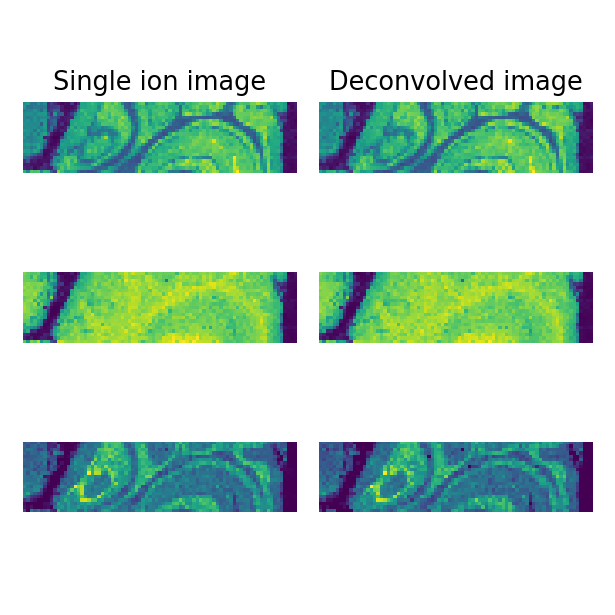

In [25]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single ion image')
plt.subplot(3, 2, 2)
plt.title('Deconvolved image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(control_peak_images['cerebellum'][..., i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images['cerebellum'][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/cerebellum_example_images.png', dpi=300)

<IPython.core.display.Javascript object>


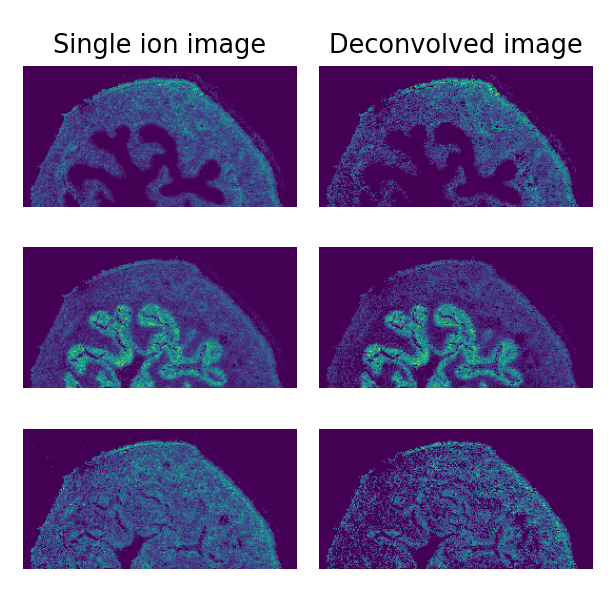

In [26]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single ion image')
plt.subplot(3, 2, 2)
plt.title('Deconvolved image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(control_peak_images['bladder'][..., i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images['bladder'][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/bladder_example_images.png', dpi=300)

The deconvolved ion images on the right need to be qualitatively similar to the standard single ion images on the left. The only source of differences between the image should be due to a strict selection of signals by masserstein in order to get an annotation with a high m/z accuracy.  

The masserstein parameters for annotation are selected in a way that allows the algorithm to discard signals if they doesn't match the corresponding theoretical m/z very well. This may cause a decrease in signal intensity of lipids in many pixels, which may change the quantitative properties of the spatial distribution, but the qualitative distribution should remain the same. Note that the correct quantitative distribution will be obtained in Notebook 3 with a different set of masserstein parameters.  

Inspect the distribution of the average proportions:

<IPython.core.display.Javascript object>


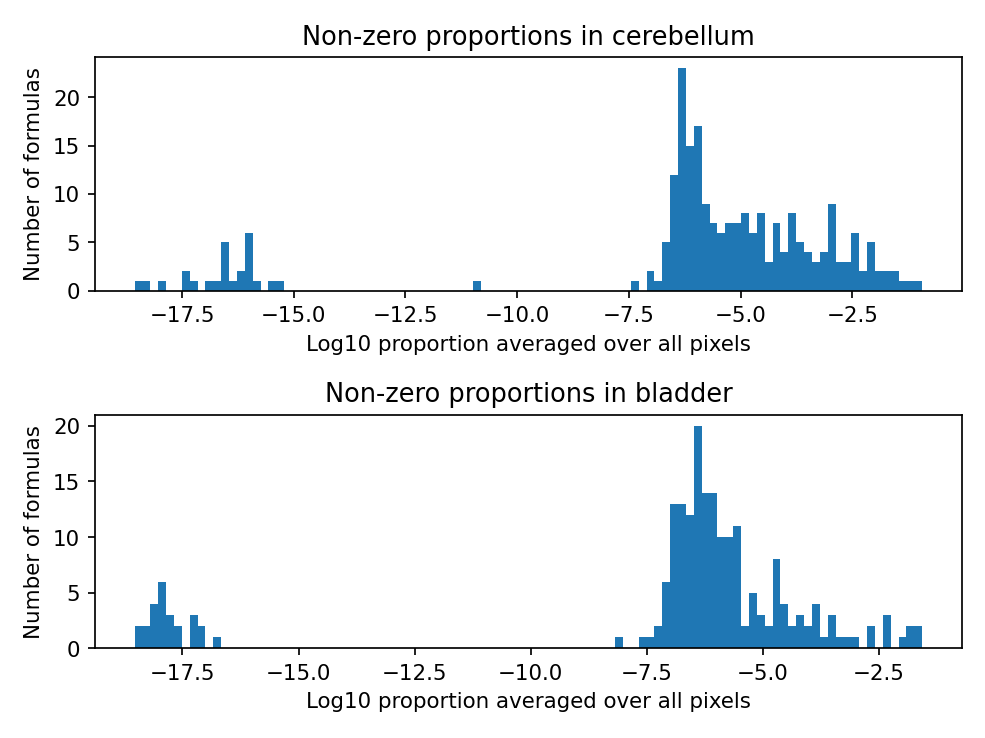

Number of non-zero proportions in cerebellum 235
Number of non-zero proportions in bladder 205


In [27]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    pvect = proportions_in_whole[n]
    plt.hist(np.log10(pvect[pvect>0]), bins=100)
    plt.title('Non-zero proportions in ' + n)
    plt.xlabel('Log10 proportion averaged over all pixels')
    plt.ylabel('Number of formulas')
    print('Number of non-zero proportions in', n, sum(pvect>0))
plt.tight_layout() 

These distributions are markedly different than the ones obtained from the average spectra.  
The higher mode has a relatively similar range for both strategies (from $10^{-8}$ to $10^{-1}$), but there are many more lipids and the distribution seems more regular. We also get a lower intensity mode.   

Inspect the number of pixels for which an ion was detected:

<IPython.core.display.Javascript object>


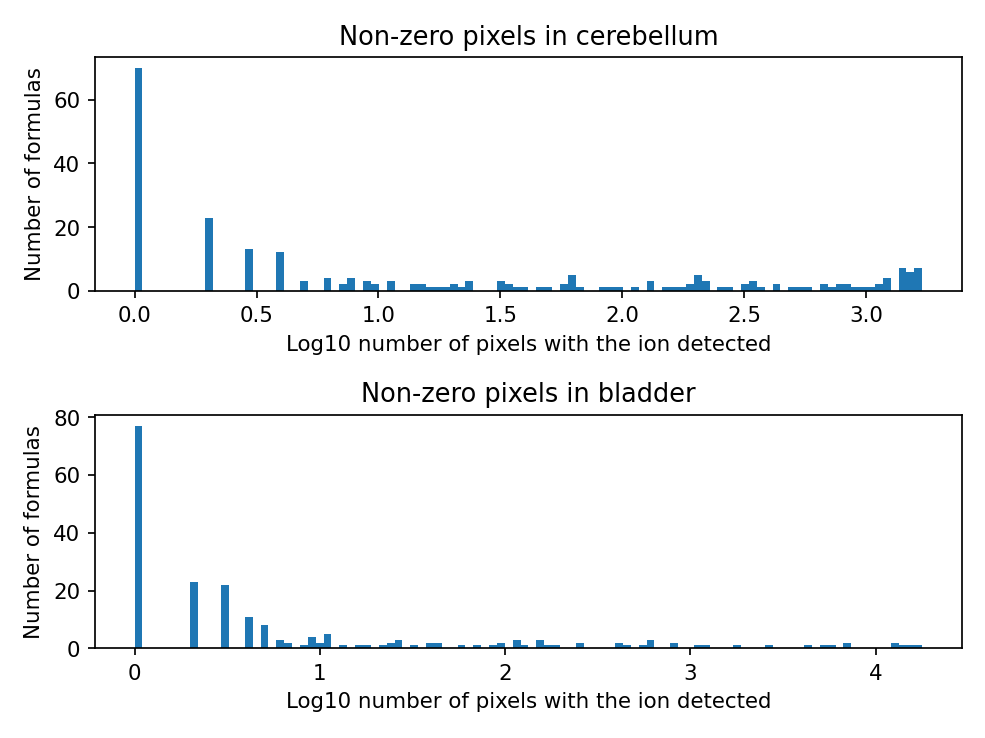

Number of lipids with at least one pixel with a non-zero proportion in cerebellum 238
Number of lipids with at least one pixel with a non-zero proportion in bladder 211


In [28]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    nvect = number_of_nonzero_pixels[n]
    plt.hist(np.log10(nvect[nvect>0]), bins=100)
    plt.title('Non-zero pixels in ' + n)
    plt.xlabel('Log10 number of pixels with the ion detected')
    plt.ylabel('Number of formulas')
    print('Number of lipids with at least one pixel with a non-zero proportion in', n, sum(nvect>0))
plt.tight_layout() 

Check the correlation between the average proportions in the whole image (interpreted as the contribution to the total signal) and the number of pixels with a non-zero proportion (interpreted as the spatial prevalence of the lipid):

<IPython.core.display.Javascript object>


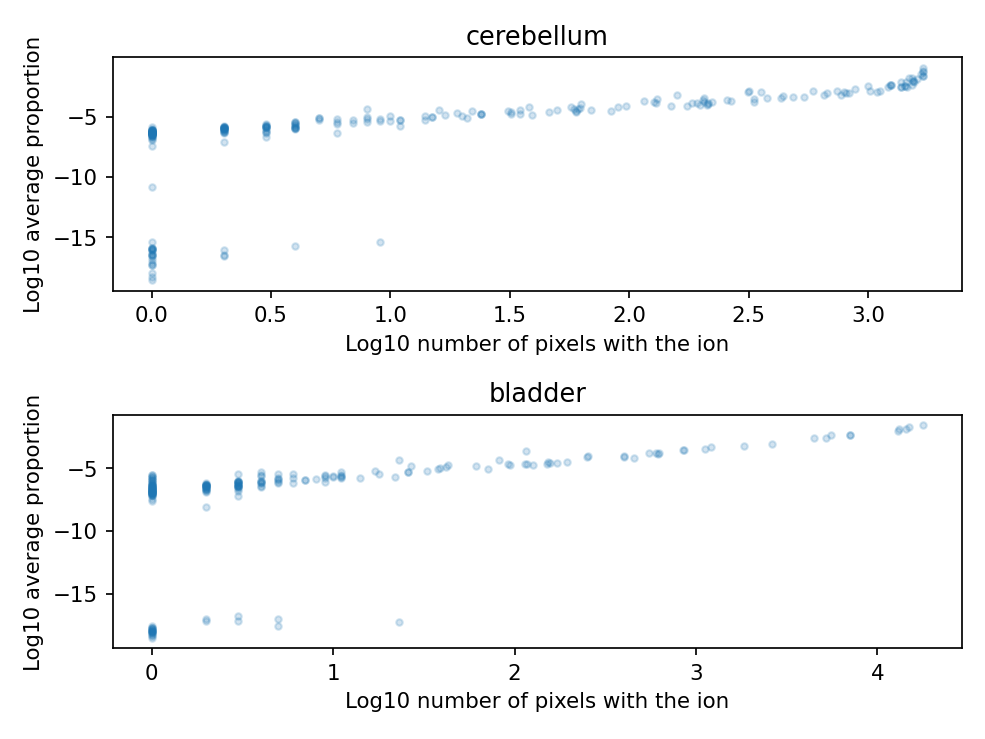

In [29]:
plt.figure()
for i,n in enumerate(image_names):
    plt.subplot(211+i) 
    nvect = number_of_nonzero_pixels[n]
    pvect = proportions_in_whole[n]
    is_present = pvect > 0  # implies nvect > 0
    present_nvect = nvect[is_present]
    present_pvect = pvect[is_present]
    plt.plot(np.log10(present_nvect), np.log10(present_pvect), '.', alpha=0.2)
    plt.title(n)
    plt.xlabel('Log10 number of pixels with the ion')
    plt.ylabel('Log10 average proportion')
plt.tight_layout() 

Select the threshold of proportions for an ion to be considered present in the spectrum:  

In [30]:
proportion_threshold_strategy2 = 1e-10  # the proportions needs to be above this threshold
# pixel_presence_threshold = 400  # disabled

In [31]:
is_annotated_strategy2 = {}
for n in image_names:
    to_keep_prop = proportions_in_whole[n] > proportion_threshold_strategy2
    # to_keep_pix = number_of_nonzero_pixels[n] > pixel_presence_threshold
    to_keep = to_keep_prop# *to_keep_pix
    is_annotated_strategy2[n] = to_keep
    print('Retained %i spectra for %s' % (sum(to_keep), n))

Retained 209 spectra for cerebellum
Retained 180 spectra for bladder


Visualize the selected region:

In [32]:
# plt.figure(figsize=(5,7))
# for i,n in enumerate(image_names):
#     plt.subplot(211+i) 
#     nvect = number_of_nonzero_pixels[n]
#     pvect = proportions_in_whole[n]
    
#     is_present = pvect > 0  # implies nvect > 0
#     present_nvect = nvect[is_present]
#     present_pvect = pvect[is_present]
    
#     lognv = np.log10(present_nvect)
#     logpv = np.log10(present_pvect)
#     lognthr = np.log10(pixel_presence_threshold)
#     logpthr = np.log10(proportion_threshold_strategy2)
    
#     plt.plot(lognv, logpv, '.', alpha=0.2)
#     curr_xlims = plt.gca().get_xlim()
#     curr_ylims = plt.gca().get_ylim()
#     plt.hlines(logpthr, lognthr, curr_xlims[1], color='grey', ls='--')
#     plt.vlines(lognthr, logpthr, curr_ylims[1], color='grey', ls='--')
#     plt.title(n)
#     plt.xlabel('Log10 number of pixels with the lipid')
#     plt.ylabel('Log10 average proportion')
# plt.tight_layout() 
# plt.savefig('Figs/peak_assignment/thorough_strategy_selection_plot.png', dpi=300)

Visualize the peak assignment:

<IPython.core.display.Javascript object>


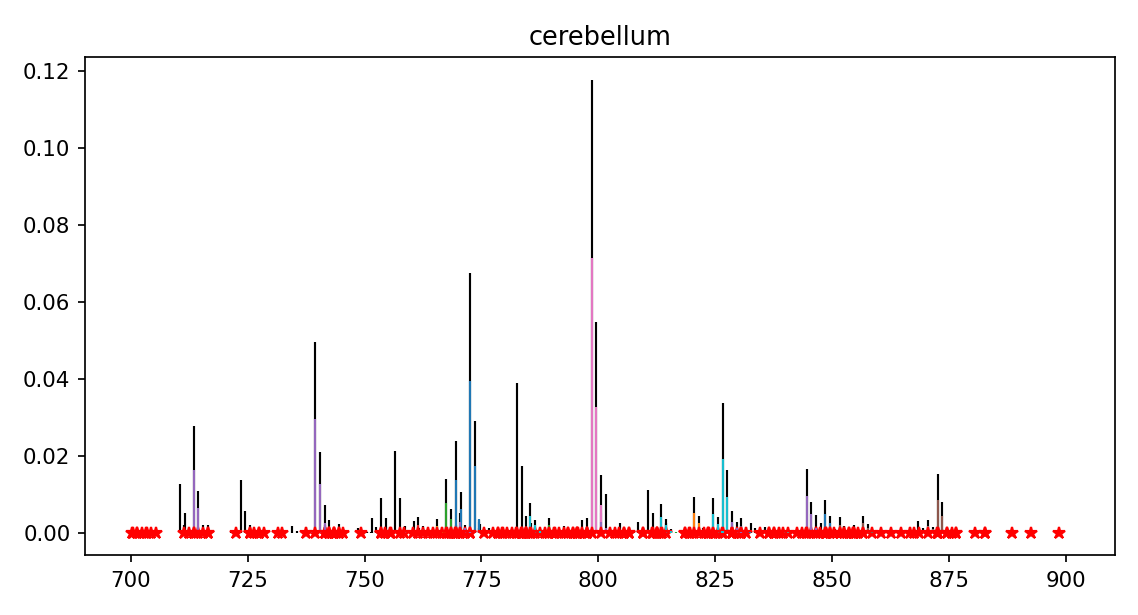

<IPython.core.display.Javascript object>


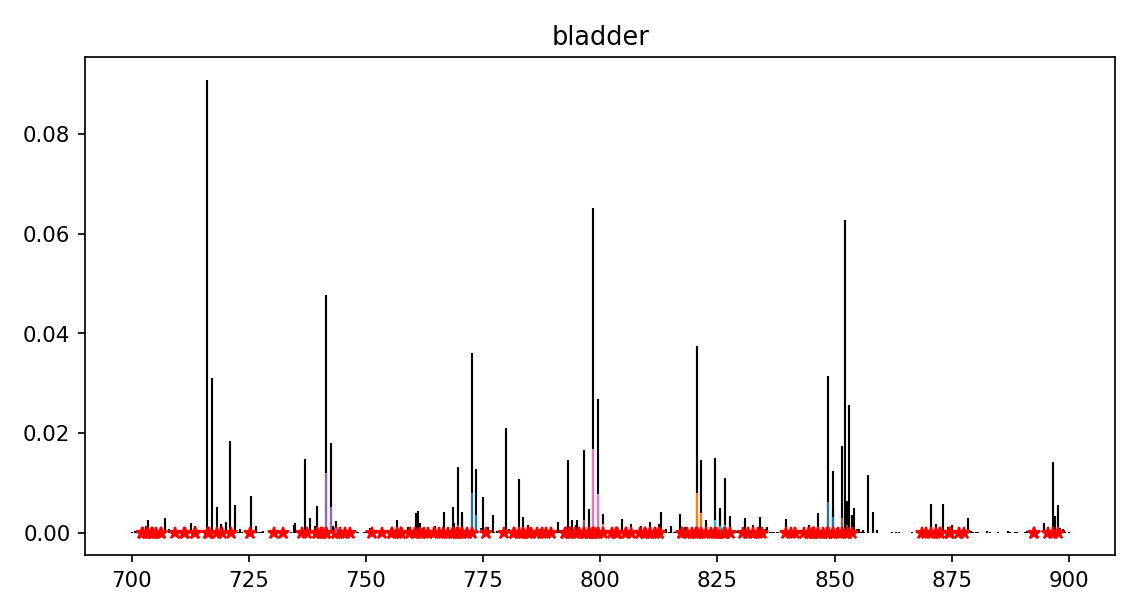

In [33]:
for i, n in enumerate(image_names):
    props = proportions_in_whole[n]
    det = is_annotated_strategy2[n]
    
    plt.figure(figsize=(7.4,4))
    plt.title(n)
    average_spectra[n].plot(profile=False, color='k', show=False)
    
    for l_id, s, p, d in zip(range(len(lipid_spectra)), lipid_spectra, props, det):
        if d:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_annotate_then_average_spectrum.png', dpi=300)
    plt.show()

Save the annotation results:

In [34]:
for i,n in enumerate(image_names):
    with open(n + '_thorough_annotation_results.tsv', 'w') as h:
        props = proportions_in_whole[n]
        det = is_annotated_strategy2[n]
        pix = number_of_nonzero_pixels[n]
        # Write the header
        h.write('\t'.join(['Formula', 'Mass', 'Initial estimation', 'Number of pixels', 'Assigned']) + '\n')
        
        # Write the annotated formulas with their initially estimated proportions
        for l_id, s, p, px, d in zip(range(len(lipid_spectra)), lipid_spectra, props, pix, det):
            mz=s.confs[0][0]
            h.write('\t'.join([s.formula, str(mz), str(p), str(px), str(d)]) + '\n')

In [35]:
proportions_in_whole['cerebellum'] > 1e-10

array([False, False, False, ..., False, False, False])

## Comparison of the annotations

Optional: Load the annotations from the previous section, to avoid re-running it

In [96]:
# annotated_formulas = {n: [] for n in image_names}
# all_proportions =  {n: [] for n in image_names}
# for n in image_names:
#     with open(n + '_thorough_annotation_results.tsv') as h:
#         next(h) 
#         for l in h:
#             l = l.strip().split()
#             if l[-1] == 'True':
#                 annotated_formulas[n].append(l[0])
#             all_proportions[n].append(float(l[2]))
# print('Loaded annotations:')
# for n in image_names:
#     print(n, len(annotated_formulas[n]))

Loaded annotations:
cerebellum 209
bladder 180


<IPython.core.display.Javascript object>


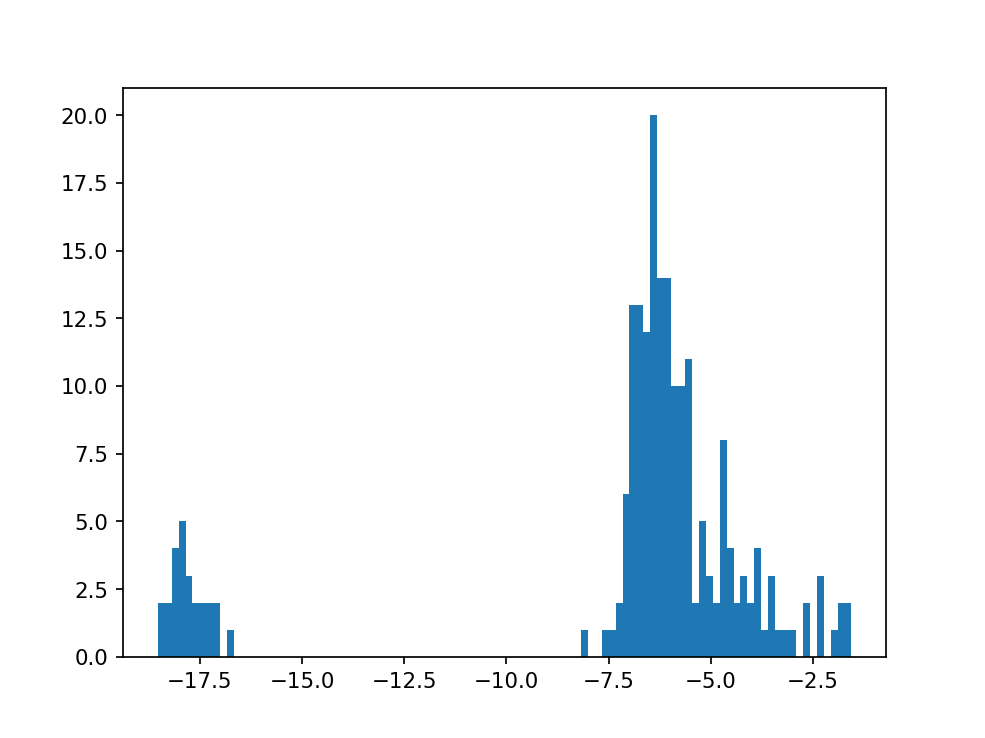

(array([ 2.,  2.,  4.,  5.,  3.,  2.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         1.,  2.,  6., 13., 13., 12., 20., 14., 14., 10., 10., 11.,  2.,
         5.,  3.,  2.,  8.,  4.,  2.,  3.,  2.,  4.,  1.,  3.,  1.,  1.,
         1.,  0.,  2.,  0.,  3.,  0.,  1.,  2.,  2.]),
 array([-18.53194419, -18.36222416, -18.19250412, -18.02278408,
        -17.85306405, -17.68334401, -17.51362397, -17.34390394,
        -17.1741839 , -17.00446386, -16.83474383, -16.66502379,
        -16.49530375, -16.32558372, -16.15586368, -15.98614364,
        -15.81642361, -15.64670357, -15.47698354, -15.3072635 ,
        -15.13754346, -14.96782343, -14.79810339, -14.62838335,
        -14.45866332, -14.28894328, -14.11922324, 

In [97]:
plt.figure()
p = np.array(all_proportions['bladder'])
p = p[p>0]
plt.hist(np.log10(p), bins=100)

Check if any formula belongs to more than one class

In [63]:
annotated_classes = {n: [set(formula_to_classes[f]) for f in annotated_formulas[n]] for n in names}
all(len(cls) == 1 for cls in annotated_classes[n] for n in names)

True

Create tables of lipid subclasses corresponding to the annotated formulas

In [64]:
all_annotated_subclasses = list(set(scls for n in names for f in annotated_formulas[n] for scls in formula_to_subclasses[f]))
all_annotated_subclasses.sort(key = lambda x: x[-5:])
all_annotated_subclasses

['Glycerophosphocholines [GP01]',
 'Glycerophosphoethanolamines [GP02]',
 'Glycerophosphoserines [GP03]',
 'Glycerophosphoglycerols [GP04]',
 'Glycerophosphoglycerophosphates [GP05]',
 'Glycerophosphoinositols [GP06]',
 'Glycerophosphoinositol bisphosphates [GP08]',
 'Glycerophosphates [GP10]',
 'Oxidized glycerophospholipids [GP20]',
 'Ceramides [SP02]',
 'Phosphosphingolipids [SP03]',
 'Neutral glycosphingolipids [SP05]']

In [65]:
subclass_annotation_tables = {n: np.zeros((len(annotated_formulas[n]), len(all_annotated_subclasses)), dtype='bool') for n in names}
for n in names:
    for fid, f in enumerate(annotated_formulas[n]):
        for scls in formula_to_subclasses[f]:
            scls_id = all_annotated_subclasses.index(scls)
            subclass_annotation_tables[n][fid, scls_id] = True

For each annotated formula, check how many classes it corresponds to

In [66]:
print('Numbers of lipid formulas with a given number of corresponding subclasses:')
for n in names:
    print(n)
    print(np.bincount(np.sum(subclass_annotation_tables[n], axis=1)))

Numbers of lipid formulas with a given number of corresponding subclasses:
cerebellum
[  0 164  39   4]
bladder
[  0 145  34   1]


One formula corresponds to three subclasses. Every formula has at least one class.  

Check how many different subclass assignments there are

In [68]:
for n in names:
    print('Number of lipids in different subclasses in', n, ':')
    scl_counts = Counter(tuple(row) for row in subclass_annotation_tables[n])
    scl_counts = [([scl for scl, t in zip(all_annotated_subclasses, r) if t], scl_counts[r]) for r in scl_counts]
    scl_counts.sort(key = lambda x: x[1], reverse=True)
    for r in scl_counts:
        print(r)

Number of unique subclass assignments in cerebellum :
(['Glycerophosphates [GP10]'], 35)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]'], 33)
(['Glycerophosphoserines [GP03]'], 31)
(['Glycerophosphoglycerols [GP04]'], 30)
(['Phosphosphingolipids [SP03]'], 23)
(['Neutral glycosphingolipids [SP05]'], 12)
(['Oxidized glycerophospholipids [GP20]'], 9)
(['Glycerophosphocholines [GP01]'], 9)
(['Glycerophosphoethanolamines [GP02]'], 7)
(['Glycerophosphoserines [GP03]', 'Oxidized glycerophospholipids [GP20]'], 5)
(['Ceramides [SP02]'], 5)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]', 'Oxidized glycerophospholipids [GP20]'], 4)
(['Glycerophosphoinositols [GP06]'], 2)
(['Glycerophosphoglycerols [GP04]', 'Glycerophosphates [GP10]'], 1)
(['Glycerophosphoglycerophosphates [GP05]'], 1)
Number of unique subclass assignments in bladder :
(['Glycerophosphates [GP10]'], 41)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]'], 32)
(